# Figure for Polybench

In [17]:
def extract_elapsed_ms(file):
    for line in open(file, "r"):
        if "Time used: " in line:
            splited = line.split(" ")
            for s in splited:
                if "ms." in s:
                    return float(s.replace("ms.", ""))
                if "s." in s:
                    return float(s.replace("s.", "")) * 1000
    
    raise Exception("Could not find time in file")

In [18]:
# def extract(file, task_identifier):
#     for line in open(file, "r"):
#         if task_identifier in line:
#             return int(line.split(" ")[-2])
    
#     raise Exception("Could not find %s in file", task_identifier)

In [19]:
import os

def polypench_analyze(focused):
    result = {}
    path = "../data/task_polybench/"
    for dirname, subdirlist, filelist in os.walk(path):
        if dirname == path:
            for dir in subdirlist:
                result[dir] = []
            continue
        
        # skip root directory is skipped
        for fname in filelist:
            subtask = os.path.basename(os.path.normpath(dirname))
            if focused in fname:
                data = extract_elapsed_ms(dirname + "/" + fname)
                result[subtask].append(data)
        
    return result

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

poly_native = polypench_analyze("enclave_native")
poly_native = pd.DataFrame(poly_native)
poly_native = poly_native.transpose()

poly_pobf = polypench_analyze("enclave_pobf")
poly_pobf = pd.DataFrame(poly_pobf)
poly_pobf = poly_pobf.transpose()

poly = {}
poly["native"] = {}
poly["pobf"] = {}

for i in poly_native.index:
    poly["native"][i] = np.average(poly_native.loc[i])
    poly["pobf"][i] = np.average(poly_pobf.loc[i])

poly = pd.DataFrame(poly)
for i in poly.index:
    poly.loc[i, "overhead"] = ((poly.loc[i, "pobf"] / poly.loc[i, "native"]) -1) * 100

np.average(poly["overhead"])

0.20744995635101976

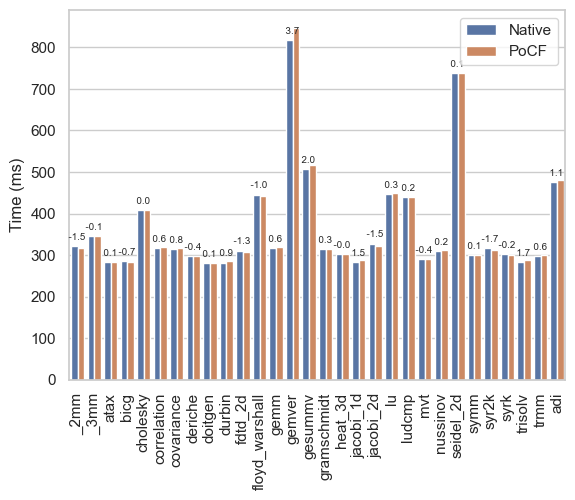

In [21]:
sns.set(style="whitegrid")
xs = []
ys = []
hue = []
overhead = []
for i in poly.index:
    xs.append(i)
    xs.append(i)
    ys.append(poly["native"][i])
    ys.append(poly["pobf"][i])
    hue.append("Native")
    hue.append("PoCF")
    
assert(len(xs) == len(ys))
g = sns.barplot(x=xs, y=ys, hue=hue)
# g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

overhead_precentage = "  " + poly["overhead"].round(1).astype(str)

g.bar_label(g.containers[0], labels = overhead_precentage, fontsize=7, padding=3)
g.set_ylabel("Time (ms)", fontsize = 12)
plt.savefig("../polybench.pdf", bbox_inches='tight')


In [23]:
poly.overhead.mean()

0.20744995635101976

# Figure for Identity Function

In [7]:
def identity_analyze(focused):
    result = []
    path = "../data/task_sample/"
    for dirname, subdirlist, filelist in os.walk(path):
        if dirname != path:
            break
        for f in filelist:
            if focused in f:
                result.append(extract_elapsed_ms(path + f,))
    return result

In [16]:
datasizes = {"1kb":1000, "10kb": 10000, "100kb":100000, "1mb":1000000, "10mb":10000000, "100mb":100000000}

identifiers = ["native", "pobf"]
identity = { id: {} for id in identifiers}

for size_str in datasizes:
    for id in identifiers:
        file_partial_name = size_str + "output_enclave_" + id + ".txt"
        data = identity_analyze(file_partial_name)
        assert(len(data) == 10)
        identity[id][size_str] = np.average(data)

identity = pd.DataFrame(identity)
for i in identity.index:
    identity.loc[i, "overhead"] = ((identity.loc[i, "pobf"] / identity.loc[i, "native"]) -1) * 100

identity.round(3).transpose()

,1kb,10kb,100kb,1mb,10mb,100mb
native,151.758,154.416,176.879,415.975,2832.107,26599.743
pobf,152.746,154.481,179.275,416.834,2831.857,26603.751
overhead,0.651,0.042,1.355,0.206,-0.009,0.015


/tmp/ipykernel_3265162/3059302278.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


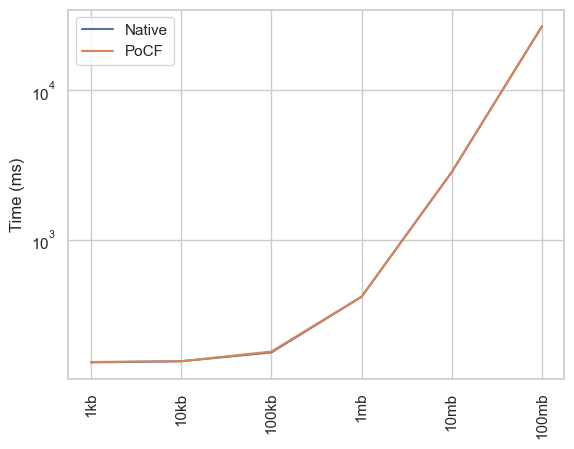

In [130]:
sns.set(style="whitegrid")
xs = []
ys = []
hue = []
overhead = []
for i in identity.index:
    xs.append(i)
    xs.append(i)
    ys.append(identity["native"][i])
    ys.append(identity["pobf"][i])
    hue.append("Native")
    hue.append("PoCF")
    
assert(len(xs) == len(ys))
g = sns.lineplot(x=xs, y=ys, hue=hue, markers=True)
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

overhead_precentage = " " + identity["overhead"].round(1).astype(str)

# g.bar_label(g.containers[0], labels = overhead_precentage, fontsize=7, padding=3)
g.set_ylabel("Time (ms)", fontsize = 12)
plt.savefig("../polybench.pdf", bbox_inches='tight')